## Phantom Simulation -

In [16]:
import numpy as np
import sigpy as sp
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive
from IPython.display import display
from PIL import Image

### 0. Functions

In [17]:
def shift_2d_array(arr_in, rl_shift, ud_shift):
#input: arr_in (input array), rl_shift (shift to right(+ve)/left(-ve) by how many pixels), ud_shift (shift upwards(+ve)/downwards(-ve) by how many pixels)
    rows, cols = arr_in.shape #get array size
    
    shifted_array_vertical = np.roll(arr_in, ud_shift, axis=0) #vertical shift
    
    arr_out = np.roll(shifted_array_vertical, rl_shift, axis=1) #horizontal shift
    
    return np.array(arr_out, dtype = float)

In [18]:
def segment_image(img_in, lower_threshold, upper_threshold):
    
    lower_mask = (img_in >= lower_threshold).astype(np.uint8)
    upper_mask = (img_in <= upper_threshold).astype(np.uint8)
    
    binary_mask = np.logical_and(lower_mask, upper_mask).astype(np.uint8) # Combine the masks to get the final binary mask
    
    segmented_image = img_in * binary_mask # Segment out the pixels with the specified intensity range
    
    non_segmented_image = img_in * (1 - binary_mask)  # Invert the binary mask to get the pixels outside the specified range
    
    return segmented_image, non_segmented_image

In [19]:
def quantify_artifacts(ground_truth, img_in):
    
    binary_mask = (ground_truth != 0).astype(np.uint8)
    
    gt_cumulative_intensity = np.sum(ground_truth) #cumulative intensity of ground truth
    ip_cumulative_intensity = np.sum(img_in * binary_mask) #in place cumulative intensity of image
    oop_cumulative_intensity = np.sum(img_in * (1 - binary_mask)) #out of place cumulative intensity of image
    
    ip_ratio = ip_cumulative_intensity/gt_cumulative_intensity
    oop_ratio = oop_cumulative_intensity/gt_cumulative_intensity
    
    return ip_ratio, oop_ratio #in place and out of place ratio

### 1. Motion Simulation

3D stack of images, additional time scale, 20 frames of images in 1 cardiac cycle, sample sequencially in k-space, then do inverse fourier transform

Displacement: sinusoidal approximation of motion

#### 1.1 Segmentation

In this part, the Shepp Logan phantom will be segmented into 2 images, with the segmented pixels representing the ones that experience motion, and the rest with no motion.

In [20]:
original_img = sp.shepp_logan([256,256], float)
print(np.unique(original_img))

lower_threshold = np.float64(0.299)
upper_threshold = np.float64(0.301)

lower_mask = (original_img >= lower_threshold).astype(np.uint8)
upper_mask = (original_img <= upper_threshold).astype(np.uint8)

segmented_img, non_segmented_img = segment_image(original_img, lower_threshold, upper_threshold)

[-5.55111512e-17  0.00000000e+00  2.00000000e-01  3.00000000e-01
  1.00000000e+00]


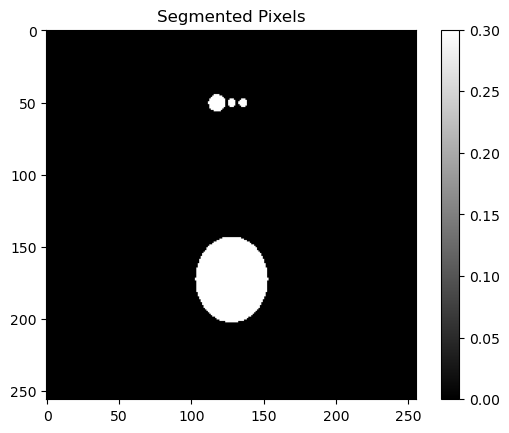

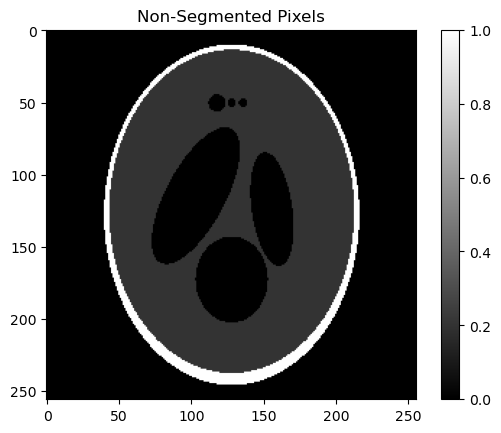

In [21]:
plt.figure()
plt.imshow(segmented_img, cmap='gray')
plt.title('Segmented Pixels')
colorbar = plt.colorbar()

plt.figure()
plt.imshow(non_segmented_img, cmap='gray')
plt.title('Non-Segmented Pixels')
colorbar = plt.colorbar()

#### 1.2 Create 3D Stack

The amplitude of oscillation should be a few pixels/voxels to reflect the pulses in the brain stem.

In [34]:
# Create a 3d array along the timescale of a stack of 2D images
num_frames = 121

#Image space
img_stack_segment = np.transpose(np.tile(segmented_img,(num_frames,1,1)),(1, 2, 0))
img_stack_non_segment = np.transpose(np.tile(non_segmented_img,(num_frames,1,1)),(1, 2, 0))

#k-space
for frame in range(num_frames):
    kspace_stack_segment[:,:,frame] = np.fft.fftshift(np.fft.fft2(img_stack_segment[:,:,frame]))
    kspace_mag_stack_segment[:,:,frame] = np.log(np.abs(kspace_stack_segment[:,:,frame]) + 1)

    kspace_stack_non_segment[:,:,frame] = np.fft.fftshift(np.fft.fft2(img_stack_non_segment[:,:,frame])) 
    kspace_mag_stack_non_segment[:,:,frame] = np.log(np.abs(kspace_stack_non_segment[:,:,frame]) + 1)
    
#-------------------
    
# def update_2d_frame(frame_index):
#     plt.imshow(kspace_mag_stack_segment[:,:,frame_index], cmap='gray')
#     plt.title(f'Frame {frame_index}')
#     plt.axis('Off')
#     plt.show()
    
# frame_slider = widgets.IntSlider(value=0, min=0, max=img_stack_segment.shape[2]-1, description='Frame') #create slider
# widgets.interactive(update_2d_frame, frame_index=frame_slider)

#-------------------

#Uncomment to see phase spectrum

# plt.figure()
# plt.imshow(img_stack_segment[:,:,20], cmap='gray')

# def update_2d_frame_kspace(frame_index):
#     plt.imshow(kspace_mag_stack[:,:,frame_index], cmap='gray')
#     plt.title(f'Frame {frame_index}')
#     plt.axis('Off')
#     plt.show()
    
# frame_slider = widgets.IntSlider(value=0, min=0, max=img_stack_segment.shape[2]-1, description='Frame') #create slider
# widgets.interactive(update_2d_frame_kspace, frame_index=frame_slider)

interactive(children=(IntSlider(value=0, description='Frame', max=120), Output()), _dom_classes=('widget-inter…

#### 1.3 Flow motion resulting in phase oscillation in phase encoding direction in k-space

In [35]:
#Apply a sinusoidal phase modification across segmented k-space frames

phase_oscillation_amplitude = np.pi #apply phase quadratic term
phase_oscillation_frequency = 20 

for i in range(num_frames):
    phase_modification = phase_oscillation_amplitude * np.sin(2 * np.pi * phase_oscillation_frequency * i / num_frames)
    kspace_stack_segment[:,:,i] = kspace_stack_segment[:,:,i] * np.exp(1j * phase_modification)
    
kspace_stack_segment_phase = np.angle(kspace_stack_segment)

In [36]:
print(np.shape(kspace_stack_segment_phase))

(256, 256, 121)


In [40]:
def update_2d_frame(frame_index):
    plt.imshow(kspace_stack_segment_phase[:,:,frame_index], cmap='gray')
    plt.title(f'k-space phase spectrum with phase modification - Frame {frame_index}')
    plt.axis('Off')
    plt.show()
    
frame_slider = widgets.IntSlider(value=0, min=0, max=img_stack_segment.shape[2]-1, description='Frame') #create slider
widgets.interactive(update_2d_frame, frame_index=frame_slider)

interactive(children=(IntSlider(value=0, description='Frame', max=120), Output()), _dom_classes=('widget-inter…

Filled row 0 with row 0 of frame 0
Filled row 1 with row 1 of frame 1
Filled row 2 with row 2 of frame 2
Filled row 3 with row 3 of frame 3
Filled row 4 with row 4 of frame 4
Filled row 5 with row 5 of frame 5
Filled row 6 with row 6 of frame 0
Filled row 7 with row 7 of frame 1
Filled row 8 with row 8 of frame 2
Filled row 9 with row 9 of frame 3
Filled row 10 with row 10 of frame 4
Filled row 11 with row 11 of frame 5
Filled row 12 with row 12 of frame 0
Filled row 13 with row 13 of frame 1
Filled row 14 with row 14 of frame 2
Filled row 15 with row 15 of frame 3
Filled row 16 with row 16 of frame 4
Filled row 17 with row 17 of frame 5
Filled row 18 with row 18 of frame 0
Filled row 19 with row 19 of frame 1
Filled row 20 with row 20 of frame 2
Filled row 21 with row 21 of frame 3
Filled row 22 with row 22 of frame 4
Filled row 23 with row 23 of frame 5
Filled row 24 with row 24 of frame 0
Filled row 25 with row 25 of frame 1
Filled row 26 with row 26 of frame 2
Filled row 27 with ro

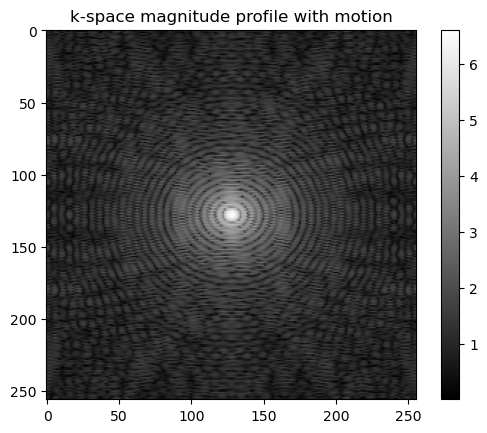

In [42]:
#Sample k-space from stack
sampled_segment_kspace = np.zeros((256,256), dtype=np.complex128)

frame_index = 0



for row in range(np.shape(kspace_stack_segment)[0]):
    current_frame = kspace_stack_segment[:,:,frame_index]
    sampled_segment_kspace[row,:] = current_frame[row,:]
    print('Filled row ' + str(row) + ' with row ' + str(row) + ' of frame ' + str(frame_index))
    
    if (row + 1) % (np.floor(num_frames/frequency).astype(int)) != 0:
#     if (row + 1) % (np.floor(np.shape(kspace_stack_segment)[0]/num_frames).astype(int)) != 0:
        frame_index += 1
    else:
        frame_index = 0

sampled_segment_kspace_mag = np.log(np.abs(sampled_segment_kspace) + 1)
sampled_segment_kspace_phase = np.angle(sampled_segment_kspace)

# plt.figure()
# plt.imshow(sampled_segment_kspace_mag, cmap='gray')
# plt.title('k-space magnitude profile with motion')
# print(np.abs(sampled_kspace))

plt.figure()
plt.imshow(sampled_segment_kspace_mag, cmap='gray')
plt.title('k-space magnitude profile with motion')
colorbar = plt.colorbar()

# plt.figure()
# plt.imshow(np.angle(kspace_stack_segment[:,:,0]), cmap='gray')
# plt.title('k-space phase profile - original')

# phase_product_conj = sampled_kspace_phase * np.conj(np.angle(kspace_stack_segment[:,:,0]))
# phase_diff_motion = np.angle(phase_product_conj)

# plt.figure()
# plt.imshow(phase_diff_motion, cmap='gray')
# plt.title('k-space phase profile difference')

Apply phase oscillation to the segment

In [43]:
# #apply phase oscillation to the segment in the PE (phase encoding) direction

# #create 2D array with oscillation in the vertical dimension
# x = np.arange(0, 256)
# y = np.arange(0, 256)
# xx, yy = np.meshgrid(x, y)

# phase_oscillation_amplitude = np.pi #apply phase quadratic term
# phase_oscillation_frequency = 20 
# phase_modification = phase_oscillation_amplitude * np.sin(2 * np.pi * phase_oscillation_frequency * yy / 256)

# sampled_segment_kspace = sampled_segment_kspace * np.exp(1j * phase_modification) #apply angle (phase) modification

# sampled_segment_kspace_mag = np.log(np.abs(sampled_segment_kspace) + 1)
# sampled_segment_kspace_phase = np.angle(sampled_segment_kspace)

# #construct resultant k-space stack

# plt.figure()
# plt.imshow(phase_modification, cmap='gray')
# colorbar = plt.colorbar()

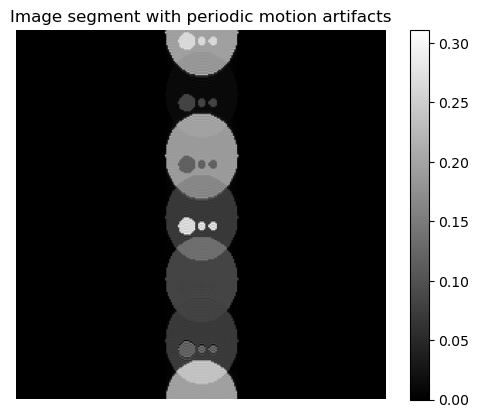

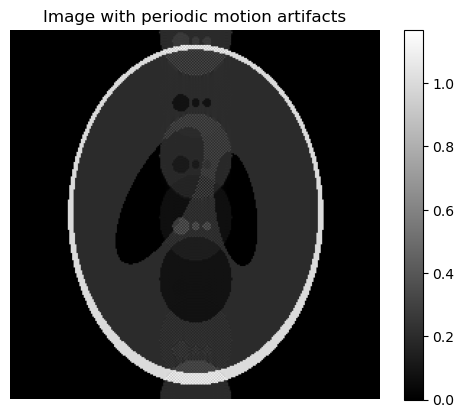

In [44]:
sampled_segment_img = np.fft.ifftn(sampled_segment_kspace)
sampled_img = non_segmented_img + sampled_segment_img

plt.figure()
plt.imshow(np.abs(sampled_segment_img), cmap='gray')
plt.title('Image segment with periodic motion artifacts')
plt.axis('Off')
colorbar = plt.colorbar()

plt.figure()
plt.imshow(np.abs(sampled_img), cmap='gray')
plt.title('Image with periodic motion artifacts')
plt.axis('Off')
colorbar = plt.colorbar()

### 4. Periodic Motion Correction

Try averaging randomly vs averaging over 1 cycle

In [69]:
average_segment_img = np.mean(img_stack_segment[:,:,:2], axis=2)

average_img_cycle = np.mean(img_stack[:,:,:20], axis=2) #image averaged over a cycle
average_img_non_cycle = np.mean(img_stack[:,:,:35], axis=2) #image averaged randomly

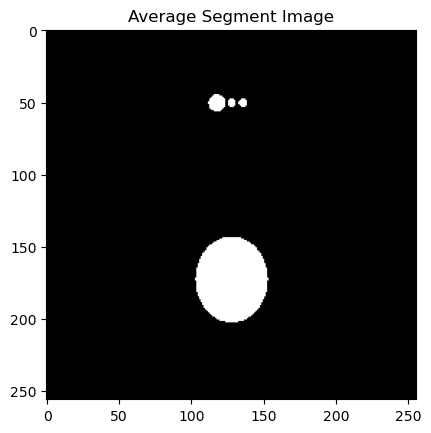

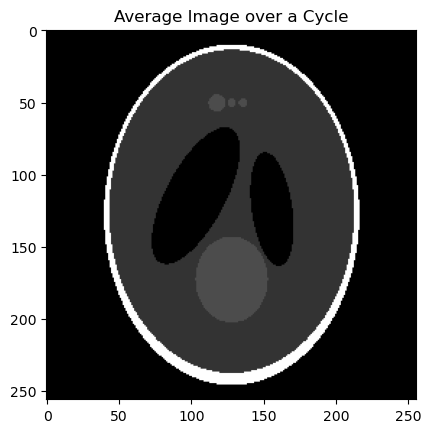

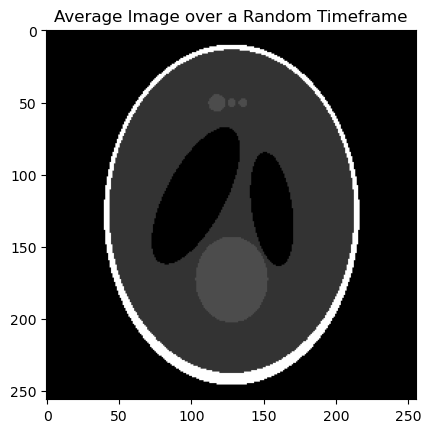

In [70]:
plt.imshow(average_segment_img, cmap='gray')
plt.title('Average Segment Image')
plt.show()

plt.imshow(average_img_cycle, cmap='gray')
plt.title('Average Image over a Cycle')
plt.show()

plt.imshow(average_img_non_cycle, cmap='gray')
plt.title('Average Image over a Random Timeframe')
plt.show()

### 5. Quantify Motion Artefacts

The percentage of cumulative pixel intensity in place will be used to quantify the effectiveness of motion correction.

In [71]:
ip_ratio, oop_ratio = quantify_artifacts(segmented_img, average_segment_img)
print(ip_ratio, oop_ratio)

1.0 0.0


In [72]:
#0.9476381104883906 0.05236188951160928

Plot barchart

Text(0, 0.5, 'Ratio')

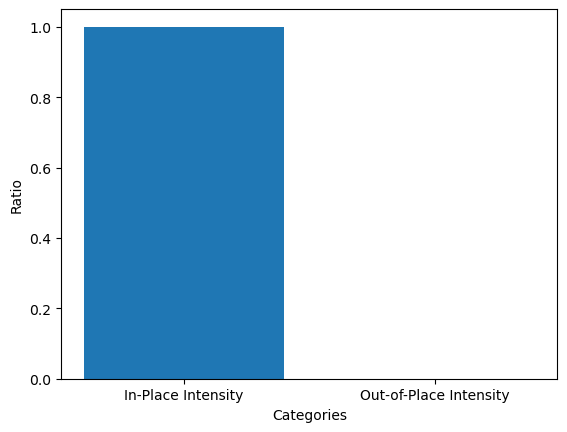

In [73]:
categories = ['In-Place Intensity', 'Out-of-Place Intensity']
values = [ip_ratio, oop_ratio]

plt.bar(categories, values)

plt.xlabel('Categories')
plt.ylabel('Ratio')

In [39]:
# Feb - averaging and bloch simulation
# March - 
# April - data needed collected 
# May - ISMRM
# June - 


In [ ]:
# 3/5, 17, 29 May Exams

In [ ]:
#parameters
#no. of frames
#TR spacing = how many TRs do we wait to come back to the same phase encoding line in the next frame

#--------
#Line = readout number we are on now
#ModLength = How many TRs until we come back to the same phase encoding line
#Reps = number of frames